# Model mismatched entity prediction analysis
In this notebook, we'll dig deeper into why the SciERC model was able to outperform the GENIA model, even though the GENIA model has more of the PICKLE corpus' vocabulary in its own vocabulary.

The approach we'll take here is to use the entities from the gold standard (PICKLE), and look at, for each of GENIA and SciERC, which of those entities were correctly predicted and which ones were not. We'll then dig deeper into the trends of which ontology types correspond most to each category, to see if differences in ontological types are responsible for the mismatches.

The script `evaluate_model_output.py` contains an option, `--save_mismatches`, which is used to generate the output used in this notebook.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import jsonlines
from ast import literal_eval
from collections import defaultdict, Counter

## Reading in the mismatches

In [60]:
all_models = pd.read_csv('../data/straying_off_topic_data/model_output/mismatch_analysis/all_dygiepp_models_mismatch_analysis_31Jan2023_MISMATCHES.csv')

In [156]:
all_models.head()

,doc_key,mismatch_type,sent_num,ent_list,ent_type,model
0,PMID1161793_abstract,1,0,"[5, 6, 'Plant_hormone']",Plant_hormone,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
1,PMID1161793_abstract,1,0,"[8, 8, 'Plant_hormone']",Plant_hormone,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
2,PMID1161793_abstract,1,0,"[35, 35, 'Organic_compound_other']",Organic_compound_other,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
3,PMID1161793_abstract,1,0,"[59, 59, 'Organic_compound_other']",Organic_compound_other,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
4,PMID1161793_abstract,1,0,"[66, 66, 'Plant_hormone']",Plant_hormone,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...


We only want to look at the full SciERC and GENIA models, so let's separate those out:

In [158]:
## CAUTION: These hardcoded indices can change if a new mismatch file from a differnt run is specified, as the
## order of the models in the dataframe is not deterministic
keep = {'GENIA':all_models.model.unique()[1],
       'SciERC':all_models.model.unique()[-1]}
keep

{'GENIA': '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/FINAL_PERF_30Jan2023/model_predictions/FINAL_PERF_30Jan2023_formatted_data_genia_predictions.jsonl',
 'SciERC': '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/FINAL_PERF_30Jan2023/model_predictions/FINAL_PERF_30Jan2023_formatted_data_scierc_predictions.jsonl'}

In [159]:
genia = all_models[all_models['model']==keep['GENIA']]
scierc = all_models[all_models['model']==keep['SciERC']]

Now, we want to make the same df as the original, excpet with `mismatch_type_GENIA` and `mismatch_type_SciERC` as columns (instead of one `mismatch_type` column and a `moddel` column). We can do this by merging the dataframes with suffixes on columns that differ, and then drop the model columns.

In [160]:
mismatches = genia.merge(scierc, how='inner', on=['doc_key', 'sent_num', 'ent_list', 'ent_type'], suffixes=('_GENIA', '_SciERC'))
mismatches = mismatches.drop(columns=['model_SciERC', 'model_GENIA'])
mismatches.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC
0,PMID1161793_abstract,0,0,"[0, 2, 'Multicellular_organism']",Multicellular_organism,0
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1
3,PMID1161793_abstract,0,0,"[11, 13, 'Organic_compound_other']",Organic_compound_other,0
4,PMID1161793_abstract,0,0,"[15, 15, 'Organic_compound_other']",Organic_compound_other,1


## Count mismatches of each category
Now that we have the mismatches for all entities for both models in one dataframe, we can count the mismatches for all the potential categories:
1. Both models correctly identify a gold standard entity
2. SciERC correctly identifies, GENIA does not
3. GENIA correctly identifies, SciERC does not
4. Both models do not identify a gold standard entity

In [161]:
both_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 1) & (mismatches['mismatch_type_SciERC'] == 1)]
scierc_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 0) & (mismatches['mismatch_type_SciERC'] == 1)]
genia_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 1) & (mismatches['mismatch_type_SciERC'] == 0)]
neither_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 0) & (mismatches['mismatch_type_SciERC'] == 0)]

In [162]:
[both_correct.shape[0], scierc_correct.shape[0], genia_correct.shape[0], neither_correct.shape[0]]

[214, 681, 67, 452]

In [163]:
# Common-sense check to make sure thhe masks worked
sum([both_correct.shape[0], scierc_correct.shape[0], genia_correct.shape[0], neither_correct.shape[0]])

1414

Now, we can make a figure! First we have to turn the numbers into a confusion matrix-like shape:

In [164]:
conf_mat = np.asarray([[both_correct.shape[0], scierc_correct.shape[0]],
           [genia_correct.shape[0], neither_correct.shape[0]]])
conf_mat_df = pd.DataFrame(conf_mat, columns=['Correct', 'Incorrect'], index=['Correct', 'Incorrect'])
conf_mat_df

,Correct,Incorrect
Correct,214,681
Incorrect,67,452


In the above dataframe, when we plot, we name the rows "SciERC" and the columns "GENIA". Let's do that:

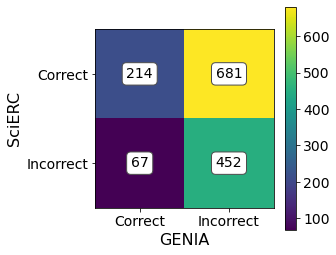

In [165]:
plt.matshow(conf_mat_df)
plt.colorbar()
tick_marks = np.arange(len(conf_mat_df.columns))
plt.xticks(tick_marks, conf_mat_df.columns)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
plt.yticks(tick_marks, conf_mat_df.index)
plt.ylabel('SciERC', fontsize=16)
plt.xlabel('GENIA', fontsize=16)
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, conf_mat_df.iloc[i,j], ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        
plt.savefig('../data/straying_off_topic_data/model_output/mismatch_analysis/mismatch_heatmap.png', bbox_inches='tight', dpi=600)

## Examining type trends in each category
Now we want to dig into what the trends are for what the labels are in each category. We'll look at a few things:
1. What types appear in each category?
2. What types appear in all categories? For those that don't appear in all, which ones appear where?
3. For each type, what percentage of each category does it make up?

We'll then make a stacked bar plot to visualize these trends.

In [166]:
both_types = both_correct.ent_type.unique()
scierc_types = scierc_correct.ent_type.unique()
genia_types = genia_correct.ent_type.unique()
neither_types = neither_correct.ent_type.unique()

In [167]:
type_dict = {'both':both_types, 'scierc':scierc_types, 'genia':genia_types, 'neither':neither_types}

### 1. What types appear in each category?

In [168]:
print('Types in each category:')
print('------------------------')
print(f'Correctly indentified by both models:\n{both_types}')
print(f'\nCorrectly identified by SciERC only:\n{scierc_types}')
print(f'\nCorrrectly identified by GENIA only:\n{genia_types}')
print(f'\nNot correctly identified by either model:\n{neither_types}')

Types in each category:
------------------------
Correctly indentified by both models:
['Protein' 'DNA' 'RNA' 'Plant_hormone' 'Multicellular_organism' 'Cell'
 'Organic_compound_other' 'Peptide' 'Polynucleotide' 'Tissue'
 'Amino_acid_monomer' 'Plant_region']

Correctly identified by SciERC only:
['Plant_hormone' 'Organic_compound_other' 'Multicellular_organism'
 'Biochemical_pathway' 'Inorganic_compound_other' 'Plant_region' 'Protein'
 'RNA' 'Biochemical_process' 'Virus' 'Cell' 'DNA' 'Tissue'
 'Polynucleotide' 'Unicellular_organism' 'Amino_acid_monomer' 'Element'
 'Peptide']

Corrrectly identified by GENIA only:
['Protein' 'RNA' 'Multicellular_organism' 'DNA' 'Cell' 'Plant_hormone'
 'Organic_compound_other']

Not correctly identified by either model:
['Multicellular_organism' 'Organic_compound_other' 'Plant_hormone' 'Cell'
 'Tissue' 'Inorganic_compound_other' 'Element' 'Protein'
 'Biochemical_process' 'DNA' 'Virus' 'Biochemical_pathway' 'Plant_region'
 'RNA' 'Peptide' 'Unicellular_organ

### 2. What types appear in all categories? For those that don't appear in all, which ones appear where?

Types that appear in all categories:

In [169]:
all_cats = set(both_types).intersection(set(scierc_types), set(genia_types), set(neither_types))
print(f'The types that appear in all categories are:\n--------------------------------------------\n{all_cats}')

The types that appear in all categories are:
--------------------------------------------
{'Cell', 'Organic_compound_other', 'RNA', 'DNA', 'Plant_hormone', 'Protein', 'Multicellular_organism'}


Types that do not appear in all categories, but may occur in more than one:

In [170]:
not_common_dict = {}
print('Types that do not appear in all categories, but may occur in more than one:')
print('----------------------------------------------------------------------------')
for key, value in type_dict.items():
    not_common = set(value) - all_cats
    print(f'The types that appear in {key}_types but not in all categories are:\n{not_common}\n')
    not_common_dict[key] = not_common

Types that do not appear in all categories, but may occur in more than one:
----------------------------------------------------------------------------
The types that appear in both_types but not in all categories are:
{'Tissue', 'Plant_region', 'Amino_acid_monomer', 'Peptide', 'Polynucleotide'}

The types that appear in scierc_types but not in all categories are:
{'Biochemical_process', 'Tissue', 'Plant_region', 'Virus', 'Amino_acid_monomer', 'Peptide', 'Polynucleotide', 'Unicellular_organism', 'Inorganic_compound_other', 'Element', 'Biochemical_pathway'}

The types that appear in genia_types but not in all categories are:
set()

The types that appear in neither_types but not in all categories are:
{'Biochemical_process', 'Tissue', 'Plant_region', 'Virus', 'Amino_acid_monomer', 'Peptide', 'Unicellular_organism', 'Inorganic_compound_other', 'Element', 'Biochemical_pathway'}



Types that appear only in one category:

In [171]:
only_one_dict = {}
print('Types that only appear in one category:')
print('----------------------------------------')
for key, value in type_dict.items():
    other_keys = list(type_dict.keys())
    other_keys.remove(key)
    all_other_sets = set().union(*[set(type_dict[k]) for k in other_keys])
    only_one = set(value) - all_other_sets
    print(f'Types that only appear in {key}_types:\n{only_one}')
    only_one_dict[key] = only_one

Types that only appear in one category:
----------------------------------------
Types that only appear in both_types:
set()
Types that only appear in scierc_types:
set()
Types that only appear in genia_types:
set()
Types that only appear in neither_types:
set()


Types that appear in SciERC correct but not in GENIA correct:

In [172]:
print('Types that appear in SciERC correct but not GENIA correct:')
print('-----------------------------------------------------------')
set(scierc_types) - set(genia_types)

Types that appear in SciERC correct but not GENIA correct:
-----------------------------------------------------------


{'Amino_acid_monomer',
 'Biochemical_pathway',
 'Biochemical_process',
 'Element',
 'Inorganic_compound_other',
 'Peptide',
 'Plant_region',
 'Polynucleotide',
 'Tissue',
 'Unicellular_organism',
 'Virus'}

### 3. For each type, what percentage of each category does it make up?
Here, we'll start making figures to get a better understanding of what's going on, as just looking at lists of types in the above sections isn't actually helpful.

#### Identified type proportions
First, let's get the proportion of each type correctly identified by each model.

In [173]:
all_ent_types = mismatches.ent_type.unique()
all_ent_types

array(['Multicellular_organism', 'Plant_hormone',
       'Organic_compound_other', 'Protein', 'DNA', 'Cell', 'RNA',
       'Tissue', 'Biochemical_pathway', 'Inorganic_compound_other',
       'Element', 'Plant_region', 'Biochemical_process', 'Virus',
       'Peptide', 'Unicellular_organism', 'Polynucleotide',
       'Amino_acid_monomer'], dtype=object)

In [174]:
type_dict

{'both': array(['Protein', 'DNA', 'RNA', 'Plant_hormone', 'Multicellular_organism',
        'Cell', 'Organic_compound_other', 'Peptide', 'Polynucleotide',
        'Tissue', 'Amino_acid_monomer', 'Plant_region'], dtype=object),
 'scierc': array(['Plant_hormone', 'Organic_compound_other',
        'Multicellular_organism', 'Biochemical_pathway',
        'Inorganic_compound_other', 'Plant_region', 'Protein', 'RNA',
        'Biochemical_process', 'Virus', 'Cell', 'DNA', 'Tissue',
        'Polynucleotide', 'Unicellular_organism', 'Amino_acid_monomer',
        'Element', 'Peptide'], dtype=object),
 'genia': array(['Protein', 'RNA', 'Multicellular_organism', 'DNA', 'Cell',
        'Plant_hormone', 'Organic_compound_other'], dtype=object),
 'neither': array(['Multicellular_organism', 'Organic_compound_other',
        'Plant_hormone', 'Cell', 'Tissue', 'Inorganic_compound_other',
        'Element', 'Protein', 'Biochemical_process', 'DNA', 'Virus',
        'Biochemical_pathway', 'Plant_region', '

In [175]:
dfs = {'both':both_correct, 'scierc':scierc_correct, 'genia':genia_correct, 'neither':neither_correct}
type_percentages = {'both':{k:0 for k in all_ent_types}, 'scierc':{k:0 for k in all_ent_types},
                    'genia':{k:0 for k in all_ent_types}, 'neither':{k:0 for k in all_ent_types}}

for model_group, df in dfs.items():
    for type_str in all_ent_types:
        identified_total = len(df.ent_type)
        identified_this_type = len(df[df['ent_type'] == type_str].ent_type)
        identified_fraction = identified_this_type/identified_total
        type_percentages[model_group][type_str] = identified_fraction

In [176]:
type_percentages

{'both': {'Multicellular_organism': 0.07476635514018691,
  'Plant_hormone': 0.004672897196261682,
  'Organic_compound_other': 0.056074766355140186,
  'Protein': 0.5700934579439252,
  'DNA': 0.2570093457943925,
  'Cell': 0.009345794392523364,
  'RNA': 0.004672897196261682,
  'Tissue': 0.004672897196261682,
  'Biochemical_pathway': 0.0,
  'Inorganic_compound_other': 0.0,
  'Element': 0.0,
  'Plant_region': 0.004672897196261682,
  'Biochemical_process': 0.0,
  'Virus': 0.0,
  'Peptide': 0.004672897196261682,
  'Unicellular_organism': 0.0,
  'Polynucleotide': 0.004672897196261682,
  'Amino_acid_monomer': 0.004672897196261682},
 'scierc': {'Multicellular_organism': 0.14684287812041116,
  'Plant_hormone': 0.2701908957415565,
  'Organic_compound_other': 0.1527165932452276,
  'Protein': 0.030837004405286344,
  'DNA': 0.030837004405286344,
  'Cell': 0.0014684287812041115,
  'RNA': 0.0014684287812041115,
  'Tissue': 0.0014684287812041115,
  'Biochemical_pathway': 0.11160058737151249,
  'Inorgani

#### Baseline type proportions
I now want to create a bar for the type proportions for all gold standard entities. The goal here is to see whether or not the proportions of the types correctly predicted by SciERC better align with the overall proportions than GENIA's does. To do this, we'll read in the gold standard, and then iterate over the entities to get the types for each.

In [177]:
gold_docs = []
with jsonlines.open('../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_30Jan2023.jsonl') as reader:
    for obj in reader: 
        gold_docs.append(obj)

In [178]:
ent_types = defaultdict(int)
for doc in gold_docs:
    for ent_sent in doc["ner"]:
        for ent in ent_sent:
            ent_t = ent[2]
            ent_types[ent_t] += 1

In [179]:
ent_types

defaultdict(int,
            {'Multicellular_organism': 246,
             'Biochemical_process': 147,
             'Plant_region': 26,
             'Organic_compound_other': 168,
             'Biochemical_pathway': 102,
             'Plant_hormone': 248,
             'Protein': 238,
             'RNA': 9,
             'DNA': 110,
             'Cell': 7,
             'Tissue': 4,
             'Element': 5,
             'Amino_acid_monomer': 7,
             'Unicellular_organism': 10,
             'Inorganic_compound_other': 75,
             'Peptide': 7,
             'Polynucleotide': 2,
             'Virus': 3})

In [180]:
total_num = sum([v for k, v in ent_types.items()])
print(total_num)

1414


In [181]:
frac_ent_types = {k:v/total_num for k,v in ent_types.items()}

In [182]:
frac_ent_types

{'Multicellular_organism': 0.173974540311174,
 'Biochemical_process': 0.10396039603960396,
 'Plant_region': 0.018387553041018388,
 'Organic_compound_other': 0.1188118811881188,
 'Biochemical_pathway': 0.07213578500707214,
 'Plant_hormone': 0.1753889674681754,
 'Protein': 0.16831683168316833,
 'RNA': 0.006364922206506365,
 'DNA': 0.07779349363507779,
 'Cell': 0.0049504950495049506,
 'Tissue': 0.002828854314002829,
 'Element': 0.003536067892503536,
 'Amino_acid_monomer': 0.0049504950495049506,
 'Unicellular_organism': 0.007072135785007072,
 'Inorganic_compound_other': 0.05304101838755304,
 'Peptide': 0.0049504950495049506,
 'Polynucleotide': 0.0014144271570014145,
 'Virus': 0.0021216407355021216}

In [183]:
type_percentages['gold'] = frac_ent_types

#### Make figure

In [184]:
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**']

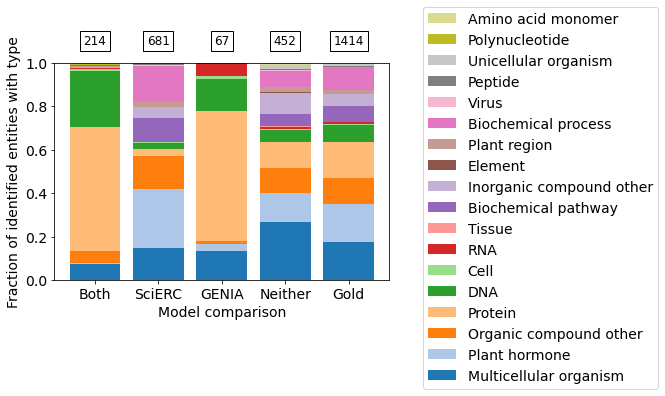

In [211]:
keys_for_labels = ['both', 'scierc', 'genia', 'neither', 'gold']
labels = ['Both', 'SciERC', 'GENIA', 'Neither', 'Gold']
total_ents = {'Both':both_correct.shape[0], 'SciERC':scierc_correct.shape[0],
              'GENIA':genia_correct.shape[0], 'Neither':neither_correct.shape[0],
             'Gold':total_num}

fig, ax = plt.subplots()
colors = [plt.cm.tab20(i) for i in range(20)]
vals_list = []
for i, type_str in enumerate(all_ent_types):
    vals = [type_percentages[k][type_str] for k in keys_for_labels]
    if i == 0:
        ax.bar(labels, vals, label=type_str, color=colors[i])#, hatch=hatches[i])
    else:
        ax.bar(labels, vals, bottom=sum(vals_list), label=type_str, color=colors[i])#, hatch=hatches[i])
    vals_list.append(np.asarray(vals))

# Add total number of entities identified over the bars
xtick_locs, xtick_labels = ax.get_xticks(), ax.get_xticklabels()
for xtick_loc, xtick_label in zip(xtick_locs, labels):
    box_text = f'{total_ents[xtick_label]}'
    t = ax.text(xtick_loc, 1.1, box_text, ha='center', va='center',
                 size=12, bbox=dict(boxstyle="square,pad=0.3", facecolor='white'))
    
ax.set_ylabel('Fraction of identified entities with type')
ax.set_xlabel('Model comparison')
handles, labels = ax.get_legend_handles_labels()
labels = [' '.join(lab.split('_')) for lab in labels]
ax.legend(handles[::-1], labels[::-1], loc=(1.1,-0.5))

plt.savefig('../data/straying_off_topic_data/model_output/mismatch_analysis/type_percentages_stacked_bar_without_fill.png', bbox_inches='tight', dpi=600)

Break down precision and recall for the types GENIA knows about vs. the ones it doesn't
* Need to know if it's doing well on the types it knows about, because if it isn't, then there may be something deeper than just the fact that it doesn't know about some types

This plot is quite informative! You can see that SciERC is much bettter at identifying `Plant_hormone`, `Organic_compound_other`, `Biochemical_pathway` and `Biochemical_process` than GENIA is, while GENIA excels at identifying `Protein` and `DNA` and `RNA`.

#### Generate summary difference number
Because the above plot is quite overwhelming visually even though it conveys important information, we're going to calculate a summary number of the differences per type between each model and the gold standard to report in the main text, and then put the barplot in the supplemental information.

Logic for generating summary number:
* The bar plot compares the proportions of each type that were predicted by each model to those present in the gold standard
* What we care about is how close the model proportion for a given type is to the gold standard proportion for that type -- how close the difference between the two numbers is to zero
* If we were to add up all the differences, whichever model vs. gold comparison is closest to zero is the one whose pattern in the bar plot is closest to that of the gold standard

Procedure:
* Make a dataframe with the proportions of each type for each bar
* Calculate the differences between each column and the gold standard, take the absolute value
* Sum down the columns

For the purpose of this summary exercise, I am only going to compare the SciERC and GENIA models vs the gold standard, and not include the Both and Neither categories -- I don't necessarily think those numbers will be illuminating.

In [186]:
prop_df = pd.DataFrame.from_dict(type_percentages, orient='columns')
prop_df

,both,scierc,genia,neither,gold
Multicellular_organism,0.074766,0.146843,0.134328,0.267699,0.173975
Plant_hormone,0.004673,0.270191,0.029851,0.134956,0.175389
Organic_compound_other,0.056075,0.152717,0.014925,0.112832,0.118812
Protein,0.570093,0.030837,0.597015,0.121681,0.168317
DNA,0.257009,0.030837,0.149254,0.053097,0.077793
Cell,0.009346,0.001468,0.014925,0.006637,0.004950
RNA,0.004673,0.001468,0.059701,0.006637,0.006365
Tissue,0.004673,0.001468,0.000000,0.004425,0.002829
Biochemical_pathway,0.000000,0.111601,0.000000,0.057522,0.072136
Inorganic_compound_other,0.000000,0.048458,0.000000,0.092920,0.053041


In [187]:
(prop_df.genia - prop_df.gold).abs()

Multicellular_organism      0.039646
Plant_hormone               0.145538
Organic_compound_other      0.103887
Protein                     0.428698
DNA                         0.071460
Cell                        0.009975
RNA                         0.053337
Tissue                      0.002829
Biochemical_pathway         0.072136
Inorganic_compound_other    0.053041
Element                     0.003536
Plant_region                0.018388
Biochemical_process         0.103960
Virus                       0.002122
Peptide                     0.004950
Unicellular_organism        0.007072
Polynucleotide              0.001414
Amino_acid_monomer          0.004950
dtype: float64

In [188]:
scierc_vs_gold = (prop_df.scierc - prop_df.gold).abs().sum()
genia_vs_gold = (prop_df.genia - prop_df.gold).abs().sum()

In [189]:
scierc_vs_gold, genia_vs_gold

(0.4722400496814943, 1.1269395596276044)

It turns out that there's no guarantee that these numbers end up being between 0 and 1, because we're taking the difference across columns. Options:
* Have the less similar model have the greater summary number
    * Not ideal because it's nonintuitive
    * But, could call it a "distance" and just say that lower is better
* Still subtract from 1, just have negative numbers
    * Not ideal because it makes the visualization funky
* Normalize between 0 and 1
    * Feels unnecesarily complicated
* Plot the numbers with the y-axis reversed, so the model comparison with the bar that reaches lower is the less similar comparison
    * Also feels unnecesarily complicated

#### Plot summary numbers

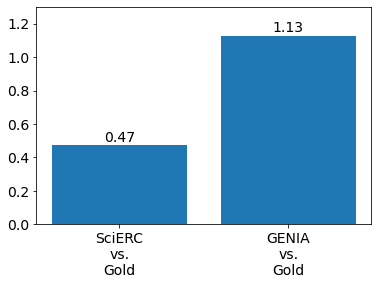

In [190]:
labels = ['SciERC\nvs.\nGold', 'GENIA\nvs.\nGold']
values = [scierc_vs_gold, genia_vs_gold]

fig, ax = plt.subplots(1)
ax.bar(labels, values)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
               bar.get_height()), ha='center', va='center',
               size=14, xytext=(0,8),
               textcoords='offset points')
ax.set_ylim((0,1.3))    
plt.savefig('../data/straying_off_topic_data/model_output/mismatch_analysis/summary_distance.png', bbox_inches='tight', dpi=600)

## Get recall per type
We also want to be able to look at how well each model is identifying each type, to confirm that GENIA is in fact better at identifying types it knows about than ones it doesn't. Here, we'll focus on recall, as this tells us how often the models are recovering the *spans* of entities of a given type -- agnostic of the type that the model assigns on its predictions. We won't look at precision, because it doesn't make sense to do so: to calculate the precision we divide the number of correctly identified entities by the toal number of predicted entities. To break this down by type, we'd only be able to look at the precision for the types in the GENIA model that overlap with those from the PICKLE corpus, which turns out to be only `Protein`, `DNA`, and `RNA`. This metric is not agnostic to the type of the predictions like recall is, because when an entity is a fale positive, there is no gold standard entity with a relevant type that we can use for comparison instead of the predicted label. For this reason, we're leaving precision out of this analysis.

In [191]:
mismatches.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC
0,PMID1161793_abstract,0,0,"[0, 2, 'Multicellular_organism']",Multicellular_organism,0
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1
3,PMID1161793_abstract,0,0,"[11, 13, 'Organic_compound_other']",Organic_compound_other,0
4,PMID1161793_abstract,0,0,"[15, 15, 'Organic_compound_other']",Organic_compound_other,1


In [192]:
recall_per_label = {'GENIA':{}, 'SciERC':{}}
for label in mismatches.ent_type.values:
    label_df = mismatches[mismatches['ent_type'] == label]
    for model in ['GENIA', 'SciERC']:
        matched = len(label_df[label_df[f'mismatch_type_{model}'] == 1])
        gold = len(label_df)
        recall = matched/gold
        recall_per_label[model][label] = recall

In [193]:
recall_df = pd.DataFrame.from_dict(recall_per_label)

In [194]:
recall_df

,GENIA,SciERC
Multicellular_organism,0.101626,0.471545
Plant_hormone,0.012097,0.745968
Organic_compound_other,0.077381,0.690476
Protein,0.680672,0.600840
DNA,0.590909,0.690909
Cell,0.428571,0.428571
RNA,0.555556,0.222222
Tissue,0.250000,0.500000
Biochemical_pathway,0.000000,0.745098
Inorganic_compound_other,0.000000,0.440000


This comparison shows that there are also categories that GENIA *does* know about where SciERC still does much better in terms of recall. However, those terms generally speaking do not make up a large portion of the gold standard, and so don't affect the model performance as much. To confirm, we'll add the proportion of the gold standard that each of the types make up to this dataframe, and order the dataframe by the proportion that the type makes up of the gold standard. 

In [195]:
frac_types_df = pd.DataFrame.from_dict(frac_ent_types, orient='index', columns=['Gold_standard_proportion'])

In [196]:
recall_df = recall_df.merge(frac_types_df, how='outer', left_index=True, right_index=True)

In [197]:
recall_df.index = recall_df.index.str.replace('_', ' ')
recall_df.round(3).sort_values('Gold_standard_proportion', ascending=False)

,GENIA,SciERC,Gold_standard_proportion
Plant hormone,0.012,0.746,0.175
Multicellular organism,0.102,0.472,0.174
Protein,0.681,0.601,0.168
Organic compound other,0.077,0.690,0.119
Biochemical process,0.000,0.769,0.104
DNA,0.591,0.691,0.078
Biochemical pathway,0.000,0.745,0.072
Inorganic compound other,0.000,0.440,0.053
Plant region,0.038,0.654,0.018
Unicellular organism,0.000,0.100,0.007


## Identifying specific examples of mismatches
Now that we have an overview of what the discrepancy in model predictions are with regards to ontology types, let's take a look at some specific examples of entities where these disagreements occur.

In order to do this, we need to bring in the gold standard to use the doc key, sentence number and entity list to get the text of entities. We'll make a df with the sentence and the entity for each entity in the overall df, and then we can subset by mismatch type combination and look for good examples.

In [198]:
gold_path = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_08Nov2022.jsonl'
with jsonlines.open(gold_path) as reader:
    gold_data = []
    for obj in reader:
        gold_data.append(obj)

In [199]:
# Make dict so we can index using doc key
gold_dict = {d['doc_key']:d for d in gold_data}

In [200]:
def get_sent(doc_key, sent_num, gold_dict):
    """
    Get the sentence as a string using doc key and sentence number.
    """
    doc = gold_dict[doc_key]
    sent_list = doc['sentences'][sent_num]
    sent_str = ' '.join(sent_list)
    return sent_str
    
def get_ent_text(doc_key, sent_num, ent_list, gold_dict):
    """
    Get the text of the entity using doc key, sent number, and entity list.
    """
    doc = gold_dict[doc_key]
    doc_token_list = []
    for sent in doc['sentences']:
        for tok in sent:
            doc_token_list.append(tok)
    ent_list = literal_eval(ent_list)
    ent_start = ent_list[0]
    ent_end = ent_list[1] # End is inclusive
    ent_text = ' '.join(doc_token_list[ent_start:ent_end+1])
    return ent_text

In [201]:
v1 = np.vectorize(get_sent)
v2 = np.vectorize(get_ent_text)

In [202]:
mismatches['sent_text'] = v1(mismatches.doc_key, mismatches.sent_num, gold_dict)
mismatches['ent_text'] = v2(mismatches.doc_key, mismatches.sent_num, mismatches.ent_list, gold_dict)

In [203]:
mismatches.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC,sent_text,ent_text
0,PMID1161793_abstract,0,0,"[0, 2, 'Multicellular_organism']",Multicellular_organism,0,Solanum laciniatum Aiton treated with Gibberel...,Solanum laciniatum Aiton
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,Gibberellic acid
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,GA3
3,PMID1161793_abstract,0,0,"[11, 13, 'Organic_compound_other']",Organic_compound_other,0,Solanum laciniatum Aiton treated with Gibberel...,[2-chloroethyl]-trimethyl ammonium chloride
4,PMID1161793_abstract,0,0,"[15, 15, 'Organic_compound_other']",Organic_compound_other,1,Solanum laciniatum Aiton treated with Gibberel...,CCC


Now that we've got our entity texts and sentences, let's pick some examples! I'm going to look for examples from the entity type that was best identified by SciERC and GENIA, respectively (`Plant_hormone` for SciERC and `Protein` for GENIA)

In [204]:
scierc_examples = mismatches[(mismatches['mismatch_type_GENIA'] == 0) & (mismatches['mismatch_type_SciERC'] == 1) & (mismatches['ent_type'] == 'Plant_hormone')]

In [205]:
scierc_examples.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC,sent_text,ent_text
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,Gibberellic acid
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,GA3
7,PMID1161793_abstract,0,0,"[66, 66, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,GA3
10,PMID1161793_abstract,0,1,"[102, 102, 'Plant_hormone']",Plant_hormone,1,"Regarding the glyco-alkaloids , the highest pe...",GA3
12,PMID1161793_abstract,0,2,"[129, 129, 'Plant_hormone']",Plant_hormone,1,"On the other hand , early application of 1000 ...",GA3


In [206]:
scierc_examples.iloc[1,6]

'Solanum laciniatum Aiton treated with Gibberellic acid ( GA3 ) , [2-chloroethyl]-trimethyl ammonium chloride ( CCC ) , and their combinations at early and late stages of growth showed that early application of 2000 ppm CCC produced the greatest stem , leaves , and whole plant dry weight , followed by the combination of early application of 1000 ppm CCC and late application of 100 ppm GA3 ; whereas all GA3 treatments decreased the dry weight production compared with the controls .'

In [207]:
genia_examples = mismatches[(mismatches['mismatch_type_GENIA'] == 1) & (mismatches['mismatch_type_SciERC'] == 0) & (mismatches['ent_type'] == 'Protein')]

In [208]:
genia_examples.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC,sent_text,ent_text
24,PMID12744517_abstract,1,0,"[5, 5, 'Protein']",Protein,0,Nonspecific lipid transfer proteins ( nsLTPs )...,nsLTPs
25,PMID12744517_abstract,1,1,"[25, 25, 'Protein']",Protein,0,Three cDNAs coding nsLTPs from grape ( Vitis v...,nsLTPs
84,PMID12777041_abstract,1,3,"[88, 88, 'Protein']",Protein,0,A total of 26 putative CBPs were identified .,CBPs
85,PMID12777041_abstract,1,5,"[113, 113, 'Protein']",Protein,0,They are homologues of previously identified C...,CBPs
252,PMID16657524_abstract,1,1,"[29, 29, 'Protein']",Protein,0,Time sequence comparisons of the amylase zymog...,amylase


In [209]:
genia_examples.iloc[2,6]

'A total of 26 putative CBPs were identified .'